# Story


In [22]:
# Imports

# interactive widget imports
import ipywidgets as wg
from IPython.display import display


# data handling modules
import pandas as pd
import numpy as np
from datetime import datetime

# plotting imports
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

plotly.tools.set_credentials_file(username='halima.schede', api_key='0BXIz4i3MnnYF4z7QhA0')
plt.style.use('seaborn')

# web scraping
from bs4 import BeautifulSoup
import requests

# other helpers and suppress warnings
from helpers import *
from timeline_helpers import *
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

## *Data Cleaning*

### Columns description

In [2]:
tweets1 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_1.csv')
tweets1.head(1)

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll


For a proper description of each column go here: https://www.kaggle.com/fivethirtyeight/russian-troll-tweets/home

Out of these colums we have no interest in **harvested_date** and **new_june_2018**, since they contain information concerning the collection of the data and not the content itself.

In [3]:
cols_to_extract = [0,1,2,3,4,5,7,8,9,10,11,13,14]

### Data extraction

In [4]:
tweets1 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_1.csv', usecols=cols_to_extract)
tweets2 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_2.csv', usecols=cols_to_extract)
tweets3 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_3.csv', usecols=cols_to_extract)
tweets4 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_4.csv', usecols=cols_to_extract) 
tweets5 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_5.csv', usecols=cols_to_extract)
tweets6 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_6.csv', usecols=cols_to_extract)
tweets7 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_7.csv', usecols=cols_to_extract) 
tweets8 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_8.csv', usecols=cols_to_extract) 
tweets9 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_9.csv', usecols=cols_to_extract)

In [5]:
tweets = pd.concat([tweets1,tweets2,tweets3,tweets4,tweets5,tweets6,tweets7,tweets8,tweets9], axis=0)
tweets.head(1)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,1052,9636,253,NaN,Right,0,RightTroll


In [6]:
# delete not needed variables from memory
del tweets1
del tweets2
del tweets3
del tweets4
del tweets5
del tweets6
del tweets7
del tweets8
del tweets9

### Data formats

The different data columns are transformed into appropriated data type:

+ external_author_id, author, region, language, post_type, account_type, retweet, account_category to categorical;
+ publish_date to datetime;
+ content (the actual tweet) to string type;
+ int64 types are left as int64 since they are counting variables.




In [7]:
#complete post_type column with normal tweet category
tweets.post_type.fillna('TWEET', inplace=True)

tweets['content'] = tweets.content.astype(str)

tweets[['external_author_id', 'author', 'region', 'language', 'post_type', 'account_type', 'retweet', 'account_category']] = \
tweets[['external_author_id', 'author', 'region', 'language', 'post_type', 'account_type', 'retweet', 'account_category']].astype('category')

tweets['publish_date'] = pd.to_datetime(tweets['publish_date'], format='%m/%d/%Y %H:%M')

tweets.dtypes

external_author_id          category
author                      category
content                       object
region                      category
language                    category
publish_date          datetime64[ns]
following                      int64
followers                      int64
updates                        int64
post_type                   category
account_type                category
retweet                     category
account_category            category
dtype: object

## Dataset description

### General Numbers and Statistics

In [8]:
print('The total number of tweets in the unfiltered dataset is {}'.format(tweets.shape[0]))

The total number of tweets in the unfiltered dataset is 2973371


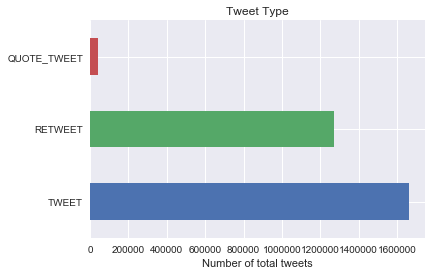

In [9]:
# retweets vs not retweets vs quotes
tweets.post_type.value_counts().plot.barh()
plt.title('Tweet Type')
plt.xlabel('Number of total tweets')
plt.show()

From this plot, we can observe the distribution of the tweets with respect to the originality of the content. 

We can visualize how the number of retweets is almost at par with the number of original tweets. This is particularly of interest because it could have been an automated action to save the Russian trolls' time while broadcasting their messages.

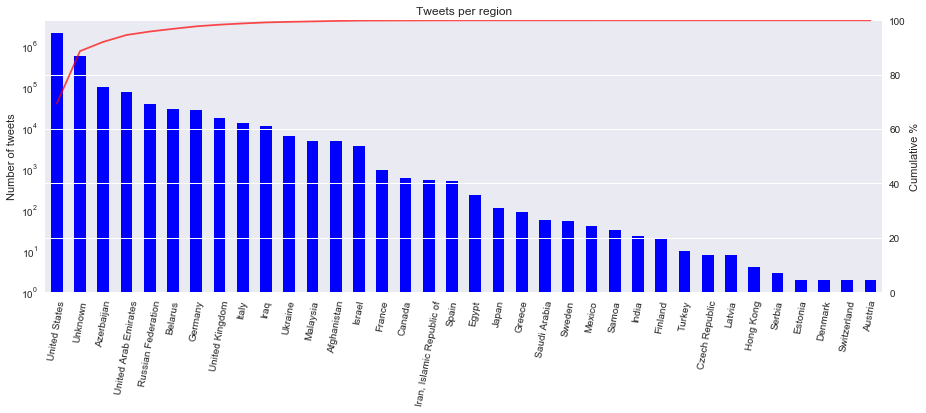

In [10]:
# Show plot region
fig = plt.figure(num=None, figsize=(15, 5))
tweets.region.value_counts().plot.bar(log = True, color = 'blue')
plt.ylabel('Number of tweets')
plt.title('Tweets per region')
plt.xticks(rotation=80)
plt.grid(False)
ax2 = fig.gca().twinx()
ax2.plot(tweets.region.value_counts().values.cumsum()/tweets.region.value_counts().values.sum()*100, color='red', alpha=0.7)
ax2.set_ylabel('Cumulative %')
ax2.set_ylim([0, 100])
plt.show()

According to the barplot, there are 35 different regions from which the tweets originated. Note that the plot is in a logarithmic scale, implying that around 75% of the tweets originated in the United States and around 90% from US + unknown region. The rest of the countries demonstrate how the Russian Trolls did their best to hide the fact that they had been tampering with the Twitter Feed.

### Authors and followers

Authors are defined by their twitter username. To understand to what extent a single author can influence the Twitter newsfeed, one needs to take into consideration different aspects:

+ each author reaches through time different followers, which is a quantity that shows how many people could have potentially read the author's tweets
+ each author has been assigned to a certain account_category that defines the troll's purpose and main tweeting subject


There are 2848 unique authors. Divided in categories in this way:


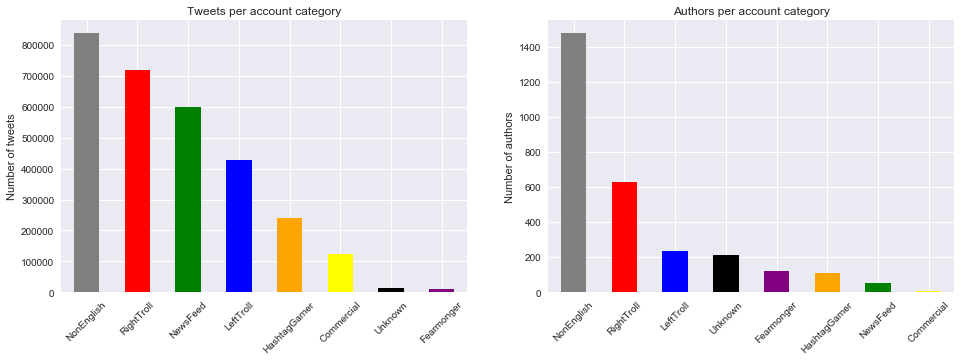

In [161]:
print('There are {} unique authors. Divided in categories in this way:'
      .format(tweets.author.cat.categories.shape[0]))

# Show bar chart of proportions of account categories
category_map = {'RightTroll' : 'red',
               'NewsFeed' : 'green',
               'LeftTroll' : 'blue',
               'NonEnglish' : 'grey',
               'Fearmonger' : 'purple',
               'HashtagGamer' : 'orange',
               'Unknown' : 'black',
               'Commercial' : 'yellow'}

color_map =map(lambda cat: category_map.get(cat), tweets.account_category.value_counts().index)

plt.figure(num=None, figsize=(16, 5))
plt.subplot(1,2,1)
tweets.account_category.value_counts().plot.bar(color=color_map)
plt.ylabel('Number of tweets')
plt.title('Tweets per account category')
plt.xticks(rotation=45)

# Show bar chart of proportions of account categories
plt.subplot(1,2,2)
color_map =map(lambda cat: category_map.get(cat), tweets[['author','account_category']].drop_duplicates().account_category.value_counts().index)

tweets[['author','account_category']].drop_duplicates().account_category.value_counts().plot.bar(color=color_map)
plt.ylabel('Number of authors')
plt.title('Authors per account category')
plt.xticks(rotation=45)
plt.show()

From the plot of account categories of total tweets on the left, it is clear that the majority of tweets are in fact not English. Furthermore, minority groups include HashtagGamer, Commercial and Fearmongers. For these reasons, the rest of our analysis has a greater focus on the RightTroll, LeftTroll and sometimes NewsFeed categories. There will be greater analysis of the NewsFeed at a later milestone.

From the plot on the right, knowing that each author can belong to only one category (with the exception of fearmonger) we can say that around 1500 authors only post in a non-English language. We can also observe that the biggest difference with the preceding figure that compared the categories of the total tweets is that the NewsFeed category has very few dedicated authors. This implies that those authors involved in NewsFeed tend to tweet significantly more.

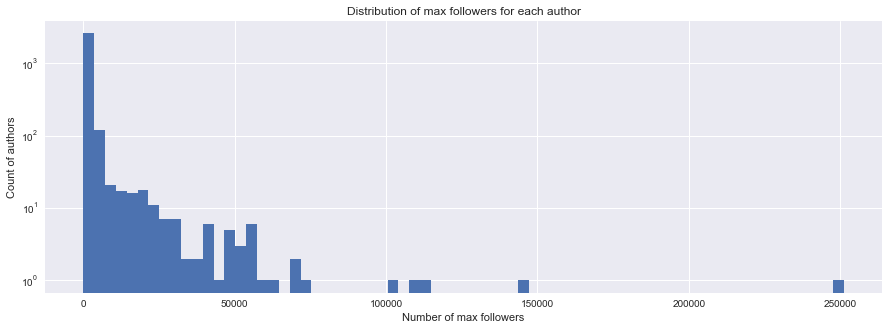

In [156]:
plt.figure(num=None, figsize=(15, 5))

tweets.groupby('author')['followers'].max().dropna().hist(log=True, bins=70)
plt.title('Distribution of max followers for each author')
plt.xlabel('Number of max followers')
plt.ylabel('Count of authors')

plt.show()

In [71]:
# Compute median and average max followers

tweets.groupby('author')['followers'].max().dropna().describe()

count      2848.000000
mean       1938.782303
std        8885.910525
min           0.000000
25%          65.000000
50%         171.500000
75%         728.250000
max      251276.000000
Name: followers, dtype: float64

It appears that there are few authors that have significantly higher number of maximum followers throughout their career. The average author has a median of 171 followers. Compare this to the author with the most followers, which is 251276. This may indicate that the great majority of accounts were not influential, in the sense that their tweets were not read by a considerable amount of people. 

In [23]:
print('NB: The user can toggle the other categories not displayed.')

data = []

for cat in reversed(tweets.account_category.cat.categories):

    acc_cat = tweets[['author','followers']][tweets.account_category == cat]
    extracted_followers = acc_cat.groupby('author')['followers'].max().dropna().values
    
    if(cat == 'RightTroll' or cat=='LeftTroll'):
        trace = go.Box(
                    y=extracted_followers[extracted_followers>0],
                    name=cat,
                    boxpoints='all'
        )
    
    else:
        trace = go.Box(
                        y=extracted_followers[extracted_followers>0],
                        name=cat,
                        boxpoints='all',
                        visible= 'legendonly'
                )
    
    data.append(trace)
    
layout = go.Layout(title = 'Distribution of account followers per category',
                   yaxis=dict(type='log',autorange=True,showgrid=True))
    
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='chart1')

NB: The user can toggle the other categories not displayed.


Interestingly we see that for categories 'RightTroll', 'LefTroll' and 'HashtagGamer' seem to have a logarithmic bimodal distribution of number of followers per account. Specifically for left and right troll there seem to be a population around 100 followers and another around 1000 followers, we currently cannot explain where this two populations may come from.n, 

In addition, we can see that the NewsFeed accounts have many more followers, perhaps because they may be more 'neutral'

## Tweets Over Time

### *General Timeline Analysis*

In [186]:
# Tweets over time
# add numerical column of ones to symbolize a tweet
tweets['tweet_counts'] = np.ones(tweets.shape[0])

# See if i can extract, within each date interval, an authors max followers value
group_followers = tweets.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                  'author'])['followers'].max().groupby(level=0).sum()
group_following =tweets.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                 'author'])['following'].max().groupby(level=0).sum()
group_authors_time = pd.DataFrame({'followers': group_followers.values,
                                   'following': group_following.values},
                                  index=group_followers.index.values)
  
# group by month
general_timeline = tweets.groupby(pd.Grouper(key='publish_date', freq='1M')).sum()
# construct labels
xlabels = list(pd.Series(group_authors_time.index.strftime(
    '%Y-%m-%d %H-%M-%S')).apply(lambda x: x[0:7]))
data = []

for col in group_authors_time:
    filtered = group_authors_time[col].copy()
    trace = go.Scatter(x=xlabels, y=filtered.values, name=col, 
                       fill='tozeroy', mode='lines')
    data.append(trace)

filtered = general_timeline['tweet_counts'].copy()
trace=go.Scatter(x=xlabels, y=filtered.values, marker = {'color' : '#00AA00'}, name='Tweet Counts', fill='tozeroy', mode='lines')
data.append(trace)

trace=go.Scatter(x=['2016-11-08','2016-11-08'], y=[0,3500000], marker = {'color' : '#FF0000'}, name='Election day', fill='tozeroy', mode='lines')
data.append(trace)

trace=go.Scatter(x=['2016-11-08','2016-11-08'], y=[0,200000], marker = {'color' : '#FF0000'}, name='Election day', fill='tozeroy', mode='lines')
data.append(trace)

In [187]:
# Create plots for following, followers, updates, tweet_counts

fig = tools.make_subplots(rows=2, cols=1)

fig.append_trace(data[0], 1, 1)
fig.append_trace(data[1], 1, 1)
fig.append_trace(data[3], 1, 1)
fig.append_trace(data[2], 2, 1)
fig.append_trace(data[4], 2, 1)

fig['layout'].update(height=600, width=800, title='General Trends Across Time')
py.iplot(fig, filename='styling-names2')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



From these time series graphs, one can visualize how the number of followers (on a monthly basis) for unique authors increases rather constantly while the number of following accounts stays approximately constant. Additionally, when comparing the number of tweets that were released over time do not seem to infuence the increase in followers when the data is taken as a whole and not analyzed by the populations within, such as account categories.

It is also apparent that there are prominent peaks in the timeseries of the number of tweets. Three of these peaks are of particular interest to this project. The first peak is between August and September of 2015, the second is in the beginning of 2016 and the last occurred the month during the elections (November 8th). These time periods are analyzed in more detail below.
What happened after the election day is of no interest for this project.

### *Language Timeline Analysis*

In [205]:
langs = tweets.language.value_counts().iloc[0:13].index.tolist()
print('The top 13 languages are:\n{}'.format(langs)) # top 13 list

The top 13 languages are:
['English', 'Russian', 'German', 'Ukrainian', 'Italian', 'Serbian', 'Uzbek', 'Bulgarian', 'LANGUAGE UNDEFINED', 'Arabic', 'Macedonian', 'French', 'Spanish']


In [206]:
language_time = tweets[(tweets.publish_date > '2015') & (tweets.publish_date < '2016-12-02')][['language', 'publish_date']]

In [207]:
data = trace_generator_language(language_time)
layout = do_layout('Date', 'Number of Tweets', 'Language as a Function of Time')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styling-names')

In [228]:
# Normalized
data = []

for lang in langs:

    filtered=count_language(lang, language_time)
    strd = pd.Series(filtered.index.strftime('%Y-%m-%d %H-%M-%S'))
    xlabels = list(strd.apply(lambda x: x[0:7]))
    
    trace = dict(
        x=xlabels,
        y=filtered.values,
        mode='lines',
        stackgroup='one',
        groupnorm='percent',
        name = lang,
    )
    
    data.append(trace)

layout = do_layout('Date', 'Fraction of Tweets (%)','Language of Tweets by Month')
    
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='stacked-area-plot-hover', validate=False)

These graphs show that the proportion of tweets by language can fluctuate quite a lot. While English and Russian remain the most dominant languages, there are some peaks affiliated with more uncommon languages including but not limited to German, Ukranian and Italian. These smaller peaks may correlate with news events that were occuring around the globe. 

One scenario where this could be the case would be the peak for the German language, which starts around May 2016. In June 2016, Trump was in Scotland for the Brexit event where he praised the movement. This made the Germans outraged, which caused a backlash. The peak in German tweets therefore may be linked in some way to this event.

To our surprise, very few spanish tweets have been released, considering the fact that spanish is the second most prominent language in the U.S.

### *Account Category Timeline Analysis*

In [14]:
# descriptions of publish dates per category

# Since the values of tweets are minimal before 2015 filter dataframe
tweets_processed = tweets.copy()
#create dataframe with publish date and account type
accounttype_time = tweets_processed[['publish_date', 'account_category']]

data = trace_generator_account_dense(accounttype_time)
layout = do_layout('Date', 'Number of Tweets','Account Type of Tweets by day')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styling-names2')

In [227]:
# Since the general timeline analysis tweets indicate that there are hardly any tweets 
# before the year 2015, a new dataset is created that filters for 2015 onwards

# Since the values of tweets are minimal before 2015 filter dataframe
tweets_processed = tweets[(tweets.publish_date > '2015')
                          & (tweets.publish_date < '2016-12-01')].copy()
#create dataframe with publish date and account type
accounttype_time = tweets_processed[['publish_date', 'account_category']]

data = trace_generator_account(accounttype_time)
layout = do_layout('Date', 'Fraction of Tweets(%)','Account Type of Tweets by Month')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styling-names2')

In [230]:
# Create dataframes for left and right trolls
righttroll = tweets_processed[tweets_processed.account_category
                              == 'RightTroll'][['author', 'publish_date',
                                                'tweet_counts', 'followers']]
lefttroll = tweets_processed[tweets_processed.account_category
                             == 'LeftTroll'][['author','publish_date',
                                              'tweet_counts','followers']]


# Create dataframe for right trolls
group_followers_right = righttroll.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                  'author'])['followers'].max().groupby(level=0).sum()
group_tweets_right =righttroll.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                 'author'])['tweet_counts'].sum().groupby(level=0).sum()
group_right = pd.DataFrame({'followers': group_followers_right.values,
                                   'tweets': group_tweets_right.values},
                                  index=group_followers_right.index.values)
#Create dataframe for left trolls

group_followers_left = lefttroll.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                  'author'])['followers'].max().groupby(level=0).sum()
group_tweets_left =lefttroll.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                 'author'])['tweet_counts'].sum().groupby(level=0).sum()
group_left = pd.DataFrame({'followers': group_followers_left.values,
                                   'tweets': group_tweets_left.values},
                                  index=group_followers_left.index.values)

trace0 = go.Scatter(
    x=list(pd.Series(group_right.index.strftime('%Y-%m-%d %H-%M-%S')).apply(lambda x: x[0:7])),
    y=group_right.followers.values,
    mode='markers',
    name='Right Troll',
    marker=dict(
        size= group_right.tweets.values * 0.002,
        sizemode='diameter',
        sizeref=2,
        sizemin=4))

trace1 = go.Scatter(
    x=list(pd.Series(group_left.index.strftime('%Y-%m-%d %H-%M-%S')).apply(lambda x: x[0:7])),
    y=group_left.followers.values,
    mode='markers',
    name='Left Troll',
    marker=dict(
        size=group_left.tweets.values * 0.002,
        sizemode='diameter',
        sizeref=2,
        sizemin=4))

data = [trace0, trace1]
layout = do_layout('Date','Number of Followers in Category',
                   'Social Power (#Tweets = diameter) of Categories by Month')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styling-names2')

### Investigating Retweets

In [211]:
RIGHT_TROLL = tweets_processed[tweets_processed.account_category
                              == 'RightTroll'][['author', 'publish_date',
                                                'tweet_counts', 'followers', 'retweet']].copy()
LEFT_TROLL = tweets_processed[tweets_processed.account_category
                             == 'LeftTroll'][['author','publish_date',
                                              'tweet_counts','followers','retweet']].copy()


In [212]:
print('The total tweets of right trolls are {} and the total tweets of left trolls\
is {}'.format(RIGHT_TROLL.shape[0], LEFT_TROLL.shape[0]))

print('The total proportion of retweets for right trolls is {} while the proportion\
for retweets of left trolls is {}'.format(
   RIGHT_TROLL[RIGHT_TROLL.retweet == 1].shape[0]/RIGHT_TROLL.shape[0],
LEFT_TROLL[LEFT_TROLL.retweet == 1].shape[0]/LEFT_TROLL.shape[0]))

The total tweets of right trolls are 289240 and the total tweets of left trollsis 210925
The total proportion of retweets for right trolls is 0.5852786613193196 while the proportionfor retweets of left trolls is 0.7449567381770772


In [213]:
# Do line chart that demonstrates the percentage of retweets over time for the 2 categories
tweets_month_right = RIGHT_TROLL.groupby(
    pd.Grouper(key='publish_date', freq='1M'))['retweet'].value_counts().groupby(level=0).sum()
retweet_right = RIGHT_TROLL.groupby(
    pd.Grouper(key='publish_date', freq='1M'))['retweet'].value_counts()

retweets_array_right = retweet_right.loc[(retweet_right.index.get_level_values('retweet') == 0)].values

# Do same for left trolls

tweets_month_left = LEFT_TROLL.groupby(
    pd.Grouper(key='publish_date', freq='1M'))['retweet'].value_counts().groupby(level=0).sum()
retweet_left = LEFT_TROLL.groupby(
    pd.Grouper(key='publish_date', freq='1M'))['retweet'].value_counts()

retweets_array_left = retweet_left.loc[(retweet_left.index.get_level_values('retweet') == 0)].values
    

In [214]:
percentage_not_retweet = pd.DataFrame({
    'Right Trolls':retweets_array_right/tweets_month_right.values * 100,
'Left Trolls' : retweets_array_left/tweets_month_left.values * 100},
    index=tweets_month_left.index.values)


In [215]:
# Plotting the change in normal tweets (not retweets)

# construct labels
xlabels = list(pd.Series(percentage_not_retweet.index.strftime(
    '%Y-%m-%d %H-%M-%S')).apply(lambda x: x[0:7]))
data = []

for col in percentage_not_retweet:
    filtered = percentage_not_retweet[col].copy()
    trace = go.Scatter(x=xlabels, y=filtered.values, name=col, mode='lines')
    data.append(trace)


In [216]:
layout = do_layout('Date', 'Percent of Original Tweets', 'Proportion of Retweets Over Time')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='retweets')

From the proportions of retweets among the two popular categories, RightTroll and LeftTroll, we can see that the proportions do correlate quite well until mid 2016 up until the election. During this period the proportion of retweets becomes much greater for the LeftTrolls (the percent of Original Tweets shrinks). The reason for this is still unclear and requires more investigation. With the use of a subject categorizer we may be able to explain why (milestone 3), for example if the subjects are always the same, it may be worthwhile simply retweeting rather than writing original content.

### Investigating Change in Account Category Over Time

In [217]:
# For each author, find dates of first 5 tweets, 5 tweets in November 2016, 5 last tweets

# Find authors that posted in November 2016
nov2016 = tweets_processed[(tweets_processed.publish_date > '2016-11-01')
                                  & (tweets_processed.publish_date < '2016-11-08')]
authors_nov2016 = nov2016.author.unique().categories.values

# create dataframe with only authors that posted during the week of the election
tweets_with_authors_election = tweets_processed[tweets_processed.author.isin(authors_nov2016)]

# Dataframe of authors of interest in first tweet wave
jul2015 = tweets_with_authors_election[(tweets_with_authors_election.publish_date
                                                > '2015-07-01') & 
                                               (tweets_with_authors_election.publish_date
                                                < '2015-08-01')]



In [218]:
tweets_with_authors_election.shape, jul2015.shape, nov2016.shape

((929475, 14), (17812, 14), (24256, 14))

In [219]:
# Visualize the distribution of account categories between the two selected periods

jul2015_grouping = jul2015.groupby('account_category').sum()
nov2016_grouping = nov2016.groupby('account_category').sum()

In [220]:
tweet_change = pd.DataFrame([jul2015_grouping.tweet_counts, nov2016_grouping.tweet_counts])
tweet_change.index = ['jul2015', 'nov2016']
tweet_change.drop(columns=['Commercial', 'Fearmonger','Unknown'], inplace=True)

# Show a percent change between the two time frames
percent_change = (nov2016_grouping - jul2015_grouping)/jul2015_grouping*100
percent_change.dropna(inplace=True)


In [221]:
data = []
xlabels = ['July 2015', 'November 2016']
for col in tweet_change:
    filtered = tweet_change[col]
    trace = go.Scatter(x=xlabels,y=filtered.values,
                       fill='tozeroy',mode= 'none',name=col)
    data.append(trace)
    

In [222]:
layout = do_layout('Time Period', 'Number of Tweets',
                   'Account Categories Between Two Time Periods of Identical Author Groups')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styling-names')




This plot has two time periods in which the authors that are selected post tweets in both periods. It is interesting to note that the only account category which decreased its number of tweets was NewsFeed.

# Which States Are Targetted?

In [17]:
# Scrape wikipedia table for american cities and states
website = requests.get('https://simple.wikipedia.org/wiki/List_of_United_States_cities_by_population').text
soup = BeautifulSoup(website,'html5lib')
My_table = soup.find('table',{'class':'wikitable sortable'})
links = My_table.find_all('a')

places = []
for link in links:
    places.append(link.get('title'))
    
    
city_clean = list(filter(None.__ne__, places)) # Drop None values

# Initialize lists for city and state names
cities = []
states = []
for x in range(0, len(city_clean)):
    if x%2 == 0:
        cities.append(city_clean[x].split(',')[0]) # Retrieve only city name, not state
    else:
        states.append(city_clean[x]) # append state name

In [16]:
# Filter for english tweets
tweets_english = tweets_processed[tweets_processed.language == 'English'].copy()
tweets_english.dropna(how='any', axis=0, inplace=True)

# count occurences of tweets for names in cities, and names in states
tweets_city = list(map(lambda x: tweets_english.content.str.contains(x).sum(), cities))
tweets_state = list(map(lambda x: tweets_english.content.str.contains(x).sum(), states))
city_counts = pd.DataFrame(data={'city' : cities, 'city_counts':tweets_city})
state_counts = pd.DataFrame(data={'state' : states, 'state_counts':tweets_state})

cities_states = pd.concat([city_counts, state_counts], axis=1)
df_citycounts_state = cities_states[['city', 'city_counts', 'state']]
grouped_state = df_citycounts_state.groupby('state')['city_counts'].sum()
ordered_state_city = grouped_state.reset_index()

### Mapping by State Occurence

In [18]:
ordered_state = state_counts.drop_duplicates().sort_values(by='state').reset_index(drop=True)
ordered_state['code'] = pd.Series(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL',
                                  'GA', 'HI','ID','IL','IN','IA','KS','KY','LA','MD','MA',
                                  'MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY',
                                  'NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX',
                                  'UT','VA','WA','WA','WI'])
ordered_state.drop(44, inplace=True)
ordered_state.loc[44] = ['Wyoming', 0, 'WY']

In [19]:
data = [ dict(
        type='choropleth',
        colorscale = 'Bluered',
        autocolorscale = False,
        locations = ordered_state['code'],
        z = ordered_state['state_counts'].astype(float).apply(lambda x: np.log(x)),
        locationmode = 'USA-states',
        text = ordered_state['state'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Number of Tweets (Log-value)")
        ) ]

layout = dict(
        title = 'States Mentioned in Tweets',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )

The map visualizes which states were mentioned more by name in tweets. It is clear that California, Texas and Florida are the most mentioned states. This data will be further interpreted with LDA to understand better the subject matter of these tweets - i.e. whether they are sports related or politically related.

### Timeline analysis of state names in tweets

In [20]:
states_plot = ordered_state.sort_values('state_counts', ascending=False).state.values
plot_states = []
for i in states_plot:
    plot_states.append(extract_states(i, tweets_english))
    data = []

for ind, i in enumerate(states_plot[0:10]):
    strd = pd.Series(plot_states[ind].index.strftime('%Y-%m-%d %H-%M-%S'))
    xlabels = list(strd.apply(lambda x: x[0:7]))
    trace = go.Scatter(x = xlabels, y = plot_states[ind].values, mode = 'lines', name=i,
                      groupnorm='percent')
    data.append(trace)

layout = do_layout('Date', 'Number of Tweets', 'State Mentions over Time')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='line-mode')

This timeline analysis provides evidence of a piece of the IRA's strategy. Indeed, during the weeks leading up to the election, the most frequent state names mentioned in tweets included Florida, Ohio, Michigan, Iowa, all of which are swing states. It should be noted that FiveThirtyEight considers the states Colorado, Florida, Iowa, Michigan, Minnesota, Ohio, Nevada, New Hampshire, North Carolina, Pennsylvania, Virginia, and Wisconsin as the main swing states for the presidential election year 2017.

Using LDA we will be able to examine better the content of the tweets, and thereby what the IRA believed the best topics were to convince the respective populations that Donald Trump deserves their vote.

### Query By User Input

In [21]:
# Querying for string defined by user

query = wg.Text(value='Query string')
display(query)

Text(value='Query string')

In [41]:
query_df = extract_states(query.get_interact_value(), tweets_english)
strd = pd.Series(query_df.index.strftime('%Y-%m-%d %H-%M-%S'))
xlabels = list(strd.apply(lambda x: x[0:7]))
trace = go.Scatter(x = xlabels, y = query_df.values, mode = 'lines',
                   name=query.get_interact_value(),
                   groupnorm='percent')
data = []
data.append(trace)
layout = do_layout('Date', 'Number of Tweets', '{} Mentions over Time'.format(
    query.get_interact_value()))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='query')